# Classification Neural Network

In [1]:
'''Needed Packages'''

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import warnings
from astropy.stats import sigma_clip
warnings.filterwarnings("ignore")

We now construct a Neural Network architecture to classify the protein structure. We follow the CATH classification for the first $2$ classes:

- Class Number (**C**)
- Architecture Number (**A**)

**C** $=0,1,2$, i.e. mainly $\alpha$ helix, mainly $\beta$ sheet, and mixed $\alpha\beta$.

We use the features computed with our algorithm, then for the clustering procedure we use the PNAS' features.





In [2]:
'''Importing Data'''

y = np.loadtxt('labels.txt', dtype = str)
path = 'coord_prot.txt'
prot = pd.read_csv(path, header=None)
prot['label'] = y
prot = prot.sort_values(by=['label'],ignore_index=True)
prot = prot.dropna()
prot = prot[prot.label != 'nan']

x = prot[prot.columns[0:15]]
x = np.array(x)
y = prot['label']
y = np.array(y)

In [3]:
'''Cleaning Data'''

x = sigma_clip(x, sigma=3, masked=False, axis=0)
y = y[~np.isnan(x).any(axis=1)]
x = x[~np.isnan(x).any(axis=1)]
print("X shape after truncation: ", x.shape) 
print("y shape after truncation: ", y.shape)

X shape after truncation:  (73772, 15)
y shape after truncation:  (73772,)


# Neural Network for the C class

We want to do a Neural Network for the C class, leaving out the $4$ and $6$ classes because they have very few samples.

In [4]:
y_true = np.zeros(y.shape,dtype=int)
y = y[y != 'nan']
for i in range(len(y)):

    g = y[i].split('.')
    g = g[0]
    y_true[i] = int(g)

In [5]:
_, counts = np.unique(y_true, return_counts = True)
c1 = counts[0]
c2 = c1 + counts[1]
c3 = c2 + counts[2]
c4 = c3 + counts[3]
c6 = c4 + counts[4]

In [6]:
x_1 = x[:c3, :]
y_label = y_true[:c3]
uniqs, counts = np.unique(y_label,return_counts= True)
print("Labels in class C: ", uniqs)
print("Number of proteins in each label: ", counts)

Labels in class C:  [1 2 3]
Number of proteins in each label:  [14498 22318 36588]


In [7]:
'''One hot encode and StandardScaler transformation'''

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_label)

# Binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_label = onehot_encoder.fit_transform(integer_encoded)

x_standard = StandardScaler().fit_transform(x_1)
print('X shape: ', x_standard.shape)
print('y shape: ', y_label.shape)

X shape:  (73404, 15)
y shape:  (73404, 3)


### Neural Network

In order to classify the protein in the class **C**, we build a NN with a input layer of $15$ neurons and a output layer of $3$ neurons, since **C** $= 1,2,3$.

For the hyperparameters of the model, we use the results of a `GridSearch`. In particoular:

- Optimizer = `Adam`
- Activation function = `relu`
- Number of Epochs $= 300$
- Batch Size $= 70$
- Dropout Rate $= 0.2$

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

In [9]:
'''Define some test model'''

def create_model_0(activation='relu',optimizer='adam',dropout_rate=0.2, L = 15):
    # 1 hidden layer
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(50,activation = activation))
    model.add(Dense(3, activation = 'softmax'))
    print(model.summary())

    # compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model0 = create_model_0()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 1,193
Trainable params: 1,193
Non-trainable params: 0
_________________________________________________________________
None


## <center>  NN with 1 hidden layer <center>


In [10]:
fit = model0.fit(X_train, y_train,
               epochs = 200, batch_size = 70,
               validation_data = (X_test,y_test),
               shuffle = True)

Train on 58723 samples, validate on 14681 samples
Epoch 1/200
58723/58723 [==============================] - 3s 53us/sample - loss: 0.5124 - accuracy: 0.7805 - val_loss: 0.4617 - val_accuracy: 0.8037
Epoch 2/200
58723/58723 [==============================] - 2s 29us/sample - loss: 0.4506 - accuracy: 0.8052 - val_loss: 0.4441 - val_accuracy: 0.8119
Epoch 3/200
58723/58723 [==============================] - 2s 31us/sample - loss: 0.4379 - accuracy: 0.8126 - val_loss: 0.4351 - val_accuracy: 0.8148
Epoch 4/200
58723/58723 [==============================] - 2s 29us/sample - loss: 0.4293 - accuracy: 0.8169 - val_loss: 0.4276 - val_accuracy: 0.8225
Epoch 5/200
58723/58723 [==============================] - 2s 29us/sample - loss: 0.4202 - accuracy: 0.8222 - val_loss: 0.4167 - val_accuracy: 0.8276
Epoch 6/200
58723/58723 [==============================] - 2s 29us/sample - loss: 0.4099 - accuracy: 0.8284 - val_loss: 0.4081 - val_accuracy: 0.8341
Epoch 7/200
58723/58723 [=========================

Epoch 55/200
58723/58723 [==============================] - 2s 32us/sample - loss: 0.3049 - accuracy: 0.8803 - val_loss: 0.3178 - val_accuracy: 0.8791
Epoch 56/200
58723/58723 [==============================] - 2s 33us/sample - loss: 0.3049 - accuracy: 0.8807 - val_loss: 0.3123 - val_accuracy: 0.8815
Epoch 57/200
58723/58723 [==============================] - 2s 32us/sample - loss: 0.3035 - accuracy: 0.8814 - val_loss: 0.3130 - val_accuracy: 0.8820
Epoch 58/200
58723/58723 [==============================] - 2s 31us/sample - loss: 0.3043 - accuracy: 0.8817 - val_loss: 0.3128 - val_accuracy: 0.8827
Epoch 59/200
58723/58723 [==============================] - 2s 31us/sample - loss: 0.3026 - accuracy: 0.8820 - val_loss: 0.3171 - val_accuracy: 0.8762
Epoch 60/200
58723/58723 [==============================] - 2s 40us/sample - loss: 0.3015 - accuracy: 0.8830 - val_loss: 0.3150 - val_accuracy: 0.8818
Epoch 61/200
58723/58723 [==============================] - 2s 40us/sample - loss: 0.3019 - ac

Epoch 163/200
58723/58723 [==============================] - 2s 32us/sample - loss: 0.2753 - accuracy: 0.8943 - val_loss: 0.2922 - val_accuracy: 0.8912
Epoch 164/200
58723/58723 [==============================] - 2s 31us/sample - loss: 0.2745 - accuracy: 0.8961 - val_loss: 0.2980 - val_accuracy: 0.8862
Epoch 165/200
58723/58723 [==============================] - 2s 32us/sample - loss: 0.2745 - accuracy: 0.8963 - val_loss: 0.2909 - val_accuracy: 0.8894
Epoch 166/200
58723/58723 [==============================] - 2s 31us/sample - loss: 0.2736 - accuracy: 0.8955 - val_loss: 0.2935 - val_accuracy: 0.8910
Epoch 167/200
58723/58723 [==============================] - 2s 31us/sample - loss: 0.2750 - accuracy: 0.8954 - val_loss: 0.2967 - val_accuracy: 0.8889
Epoch 168/200
58723/58723 [==============================] - 2s 32us/sample - loss: 0.2745 - accuracy: 0.8946 - val_loss: 0.2918 - val_accuracy: 0.8899
Epoch 169/200
58723/58723 [==============================] - 2s 32us/sample - loss: 0.27

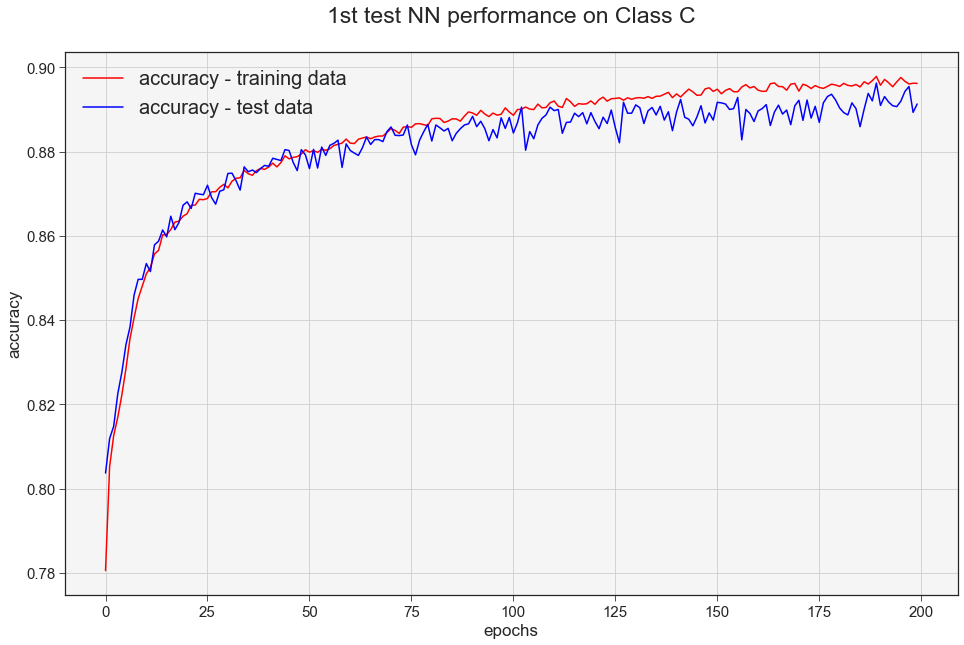

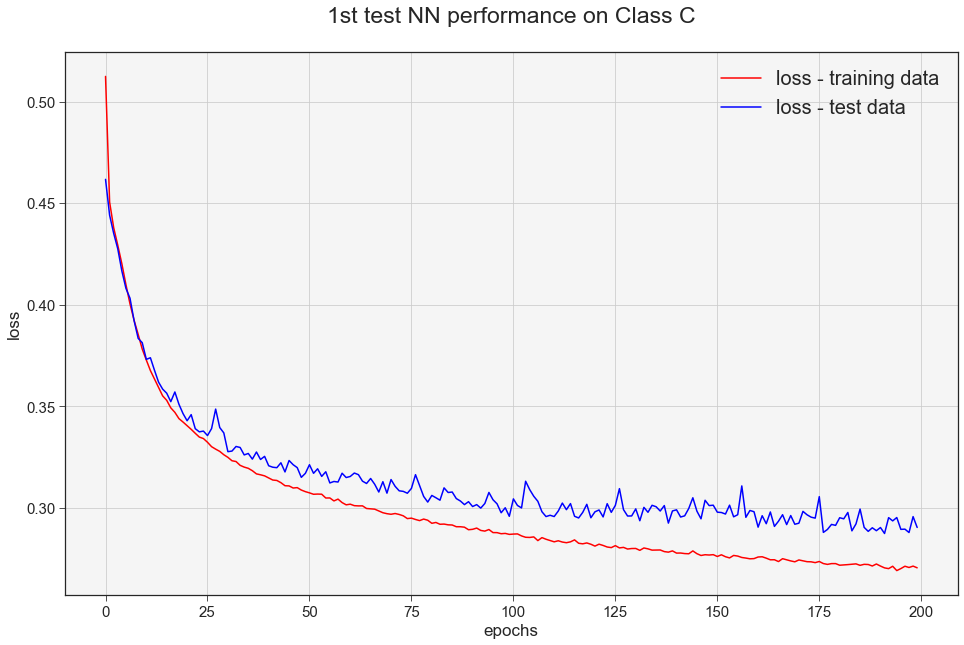

In [11]:
#fig, axs = plt.subplots(1,2, figsize=(16, 10))

for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('1st test NN performance on Class C\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

In [12]:
def create_model_1(activation='relu',optimizer='adam',dropout_rate=0.2, L = 15):
    # 2 hidden layer
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(100,activation = activation))
    model.add(Dense(50,activation = activation))
    model.add(Dense(3, activation = 'softmax'))
    print(model.summary())

    # compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model1 = create_model_1()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 7,043
Trainable params: 7,043
Non-trainable params: 0
_________________________________________________________________
None


## <center>  NN with 2 hidden layer <center>



In [13]:
fit = model1.fit(X_train, y_train,
               epochs = 200, batch_size = 70,
               validation_data = (X_test,y_test),
               shuffle = True)

Train on 58723 samples, validate on 14681 samples
Epoch 1/200
58723/58723 [==============================] - 2s 41us/sample - loss: 0.4963 - accuracy: 0.7880 - val_loss: 0.4493 - val_accuracy: 0.8162
Epoch 2/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.4348 - accuracy: 0.8167 - val_loss: 0.4251 - val_accuracy: 0.8234
Epoch 3/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.4158 - accuracy: 0.8262 - val_loss: 0.4099 - val_accuracy: 0.8336
Epoch 4/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.3970 - accuracy: 0.8352 - val_loss: 0.3909 - val_accuracy: 0.8422
Epoch 5/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.3828 - accuracy: 0.8446 - val_loss: 0.3898 - val_accuracy: 0.8493
Epoch 6/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.3713 - accuracy: 0.8508 - val_loss: 0.3695 - val_accuracy: 0.8559
Epoch 7/200
58723/58723 [=========================

Epoch 55/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.2188 - accuracy: 0.9169 - val_loss: 0.2431 - val_accuracy: 0.9102
Epoch 56/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.2160 - accuracy: 0.9175 - val_loss: 0.2454 - val_accuracy: 0.9076
Epoch 57/200
58723/58723 [==============================] - 2s 33us/sample - loss: 0.2175 - accuracy: 0.9167 - val_loss: 0.2416 - val_accuracy: 0.9096
Epoch 58/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.2142 - accuracy: 0.9179 - val_loss: 0.2494 - val_accuracy: 0.9113
Epoch 59/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.2156 - accuracy: 0.9179 - val_loss: 0.2421 - val_accuracy: 0.9112
Epoch 60/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.2116 - accuracy: 0.9197 - val_loss: 0.2369 - val_accuracy: 0.9138
Epoch 61/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.2109 - ac

Epoch 163/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.1475 - accuracy: 0.9456 - val_loss: 0.2280 - val_accuracy: 0.9242
Epoch 164/200
58723/58723 [==============================] - 2s 34us/sample - loss: 0.1439 - accuracy: 0.9459 - val_loss: 0.2194 - val_accuracy: 0.9273
Epoch 165/200
58723/58723 [==============================] - 2s 38us/sample - loss: 0.1435 - accuracy: 0.9455 - val_loss: 0.2163 - val_accuracy: 0.9274
Epoch 166/200
58723/58723 [==============================] - 2s 41us/sample - loss: 0.1451 - accuracy: 0.9460 - val_loss: 0.2169 - val_accuracy: 0.9241
Epoch 167/200
58723/58723 [==============================] - 2s 40us/sample - loss: 0.1442 - accuracy: 0.9452 - val_loss: 0.2195 - val_accuracy: 0.9290
Epoch 168/200
58723/58723 [==============================] - 2s 40us/sample - loss: 0.1449 - accuracy: 0.9448 - val_loss: 0.2246 - val_accuracy: 0.9215
Epoch 169/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.14

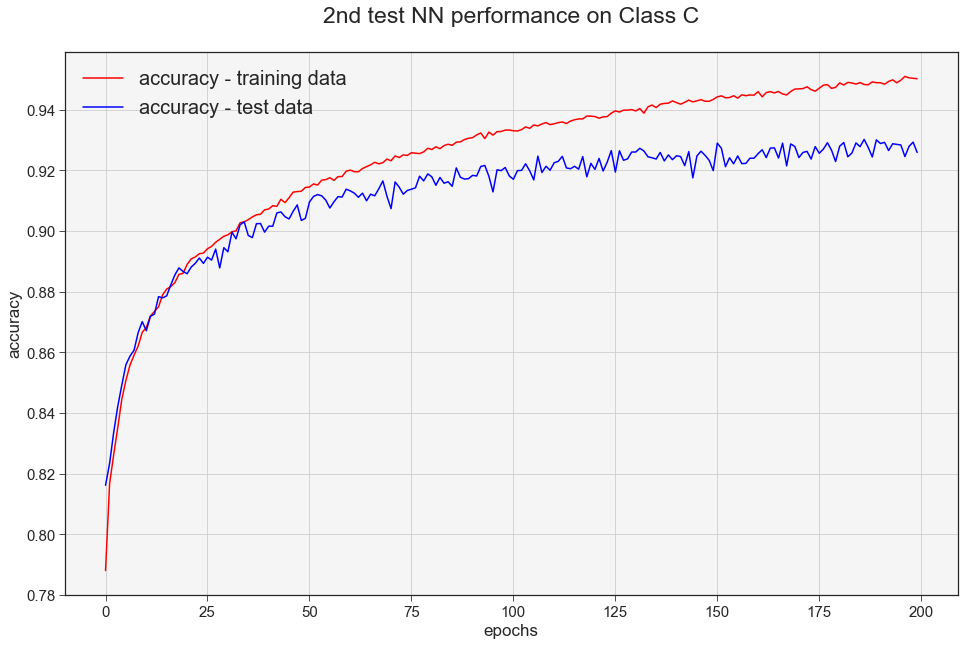

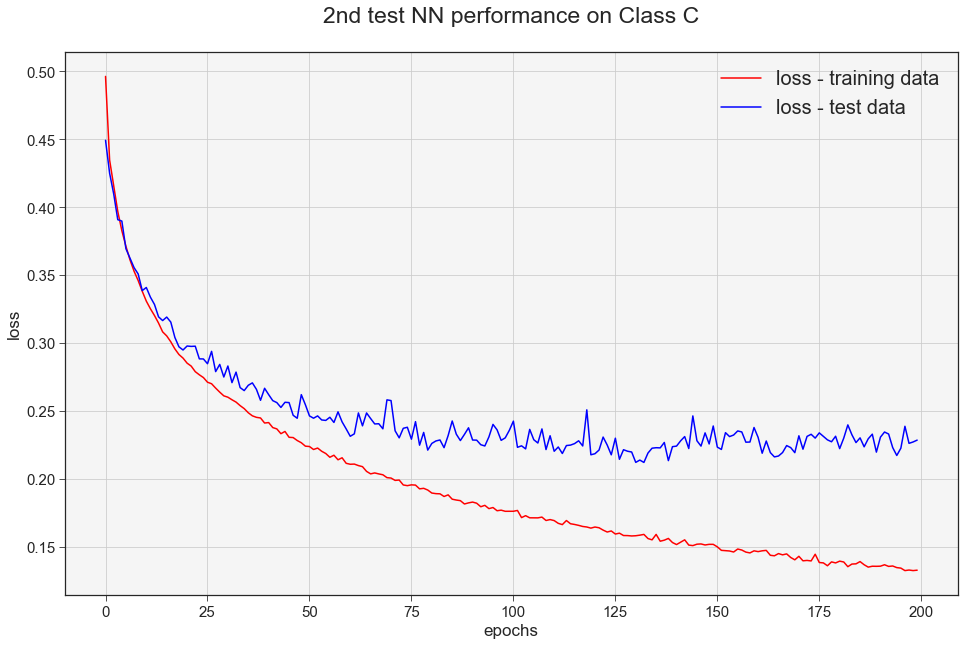

In [14]:

for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('2nd test NN performance on Class C\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

In [15]:
def create_model_2(activation='relu',optimizer='adam',dropout_rate=0.2, L = 15):
    # 3 hidden layer
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(50,activation = activation))
    model.add(Dense(100,activation = activation))
    model.add(Dense(50,activation = activation))
    model.add(Dense(3, activation = 'softmax'))
    print(model.summary())

    # compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model2 = create_model_2()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_8 (Dense)              (None, 50)                800       
_________________________________________________________________
dense_9 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 153       
Total params: 11,343
Trainable params: 11,343
Non-trainable params: 0
_________________________________________________________________
None


## <center>  NN with 3 hidden layer <center>



In [16]:
fit = model2.fit(X_train, y_train,
               epochs = 200, batch_size = 70,
               validation_data = (X_test,y_test),
               shuffle = True)

Train on 58723 samples, validate on 14681 samples
Epoch 1/200
58723/58723 [==============================] - 3s 43us/sample - loss: 0.4942 - accuracy: 0.7873 - val_loss: 0.4457 - val_accuracy: 0.8146
Epoch 2/200
58723/58723 [==============================] - 2s 38us/sample - loss: 0.4322 - accuracy: 0.8159 - val_loss: 0.4208 - val_accuracy: 0.8281
Epoch 3/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.4122 - accuracy: 0.8278 - val_loss: 0.4068 - val_accuracy: 0.8356
Epoch 4/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.3942 - accuracy: 0.8383 - val_loss: 0.3925 - val_accuracy: 0.8436
Epoch 5/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.3813 - accuracy: 0.8451 - val_loss: 0.3795 - val_accuracy: 0.8510
Epoch 6/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.3708 - accuracy: 0.8512 - val_loss: 0.3719 - val_accuracy: 0.8553
Epoch 7/200
58723/58723 [=========================

Epoch 55/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.1788 - accuracy: 0.9315 - val_loss: 0.2219 - val_accuracy: 0.9200
Epoch 56/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.1768 - accuracy: 0.9323 - val_loss: 0.2172 - val_accuracy: 0.9206
Epoch 57/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.1743 - accuracy: 0.9332 - val_loss: 0.2216 - val_accuracy: 0.9176
Epoch 58/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.1737 - accuracy: 0.9339 - val_loss: 0.2135 - val_accuracy: 0.9228
Epoch 59/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.1720 - accuracy: 0.9348 - val_loss: 0.2239 - val_accuracy: 0.9200
Epoch 60/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.1722 - accuracy: 0.9345 - val_loss: 0.2285 - val_accuracy: 0.9176
Epoch 61/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.1676 - ac

Epoch 163/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.0977 - accuracy: 0.9624 - val_loss: 0.2606 - val_accuracy: 0.9309
Epoch 164/200
58723/58723 [==============================] - 2s 35us/sample - loss: 0.0958 - accuracy: 0.9631 - val_loss: 0.2545 - val_accuracy: 0.9318
Epoch 165/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.0980 - accuracy: 0.9629 - val_loss: 0.2497 - val_accuracy: 0.9302
Epoch 166/200
58723/58723 [==============================] - 2s 37us/sample - loss: 0.0961 - accuracy: 0.9642 - val_loss: 0.2455 - val_accuracy: 0.9317
Epoch 167/200
58723/58723 [==============================] - 2s 38us/sample - loss: 0.0961 - accuracy: 0.9640 - val_loss: 0.2586 - val_accuracy: 0.9318
Epoch 168/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.0950 - accuracy: 0.9639 - val_loss: 0.2568 - val_accuracy: 0.9290
Epoch 169/200
58723/58723 [==============================] - 2s 36us/sample - loss: 0.09

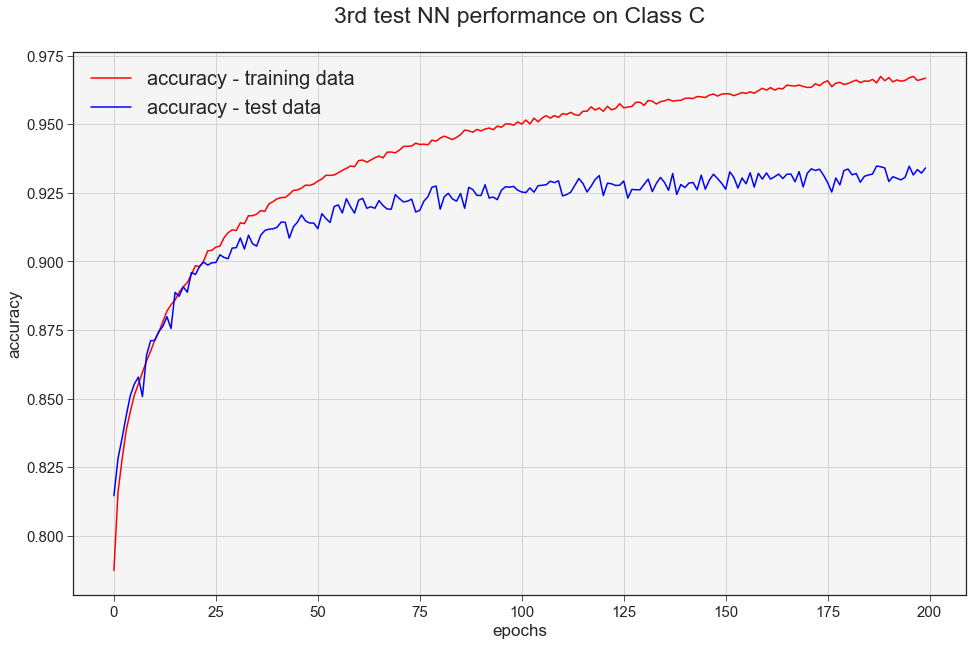

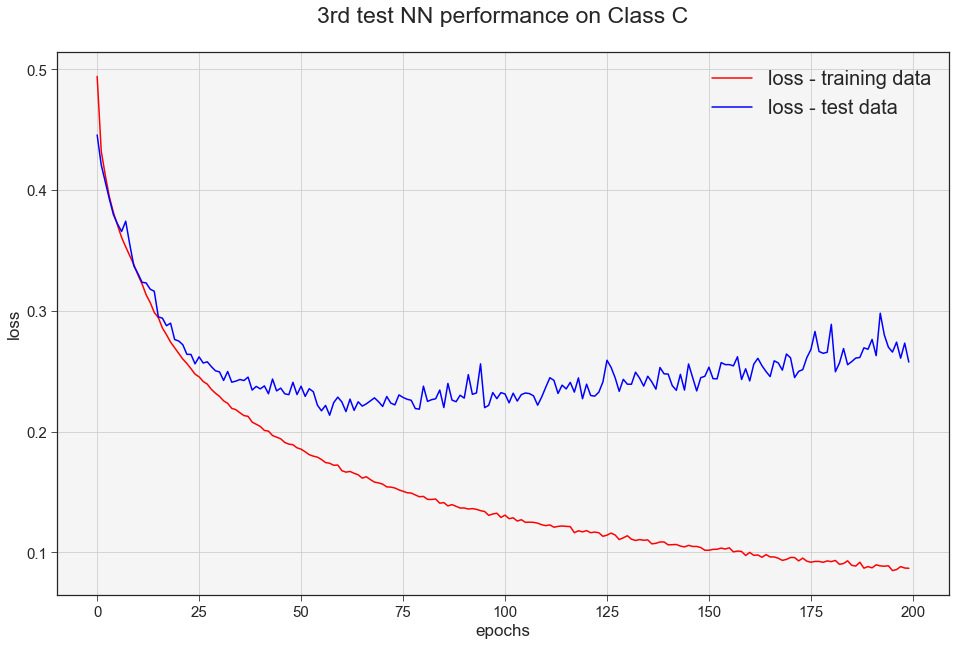

In [17]:

for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('3rd test NN performance on Class C\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

In [18]:
def create_model(activation='relu',optimizer='adam',dropout_rate=0.2, L = 15):
    # Best Model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(150,activation = activation))

    model.add(Dropout(dropout_rate))
    model.add(Dense(100,activation = activation))
    model.add(Dense(70,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(3, activation = 'softmax'))
    print(model.summary())

    # compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
     
    return model

model = create_model()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_13 (Dense)             (None, 150)               2400      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_15 (Dense)             (None, 70)                7070      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)               

## <center>  NN with 4 hidden layer <center>




In [19]:

fit = model.fit(X_train, y_train,
               epochs = 300, batch_size = 70,
               validation_data = (X_test,y_test),
               shuffle = True)

Train on 58723 samples, validate on 14681 samples
Epoch 1/300
58723/58723 [==============================] - 3s 51us/sample - loss: 0.5005 - accuracy: 0.7867 - val_loss: 0.4492 - val_accuracy: 0.8072
Epoch 2/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.4415 - accuracy: 0.8117 - val_loss: 0.4215 - val_accuracy: 0.8239
Epoch 3/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.4232 - accuracy: 0.8222 - val_loss: 0.4063 - val_accuracy: 0.8333
Epoch 4/300
58723/58723 [==============================] - 2s 42us/sample - loss: 0.4054 - accuracy: 0.8325 - val_loss: 0.3864 - val_accuracy: 0.8436
Epoch 5/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.3904 - accuracy: 0.8417 - val_loss: 0.3767 - val_accuracy: 0.8545
Epoch 6/300
58723/58723 [==============================] - 2s 41us/sample - loss: 0.3771 - accuracy: 0.8475 - val_loss: 0.3628 - val_accuracy: 0.8563
Epoch 7/300
58723/58723 [=========================

Epoch 55/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.2133 - accuracy: 0.9175 - val_loss: 0.2148 - val_accuracy: 0.9179
Epoch 56/300
58723/58723 [==============================] - 2s 41us/sample - loss: 0.2130 - accuracy: 0.9180 - val_loss: 0.2147 - val_accuracy: 0.9194
Epoch 57/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.2105 - accuracy: 0.9189 - val_loss: 0.2149 - val_accuracy: 0.9185
Epoch 58/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.2115 - accuracy: 0.9186 - val_loss: 0.2110 - val_accuracy: 0.9226
Epoch 59/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.2128 - accuracy: 0.9178 - val_loss: 0.2088 - val_accuracy: 0.9223
Epoch 60/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.2102 - accuracy: 0.9200 - val_loss: 0.2105 - val_accuracy: 0.9223
Epoch 61/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.2088 - ac

Epoch 163/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1672 - accuracy: 0.9359 - val_loss: 0.1809 - val_accuracy: 0.9360
Epoch 164/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1667 - accuracy: 0.9368 - val_loss: 0.1812 - val_accuracy: 0.9331
Epoch 165/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1683 - accuracy: 0.9363 - val_loss: 0.1802 - val_accuracy: 0.9337
Epoch 166/300
58723/58723 [==============================] - 2s 41us/sample - loss: 0.1673 - accuracy: 0.9352 - val_loss: 0.1792 - val_accuracy: 0.9353
Epoch 167/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1688 - accuracy: 0.9352 - val_loss: 0.1827 - val_accuracy: 0.9345
Epoch 168/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1657 - accuracy: 0.9365 - val_loss: 0.1800 - val_accuracy: 0.9363
Epoch 169/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.16

Epoch 217/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1576 - accuracy: 0.9387 - val_loss: 0.1723 - val_accuracy: 0.9386
Epoch 218/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1569 - accuracy: 0.9400 - val_loss: 0.1727 - val_accuracy: 0.9371
Epoch 219/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1585 - accuracy: 0.9395 - val_loss: 0.1762 - val_accuracy: 0.9394
Epoch 220/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1547 - accuracy: 0.9419 - val_loss: 0.1790 - val_accuracy: 0.9337
Epoch 221/300
58723/58723 [==============================] - 2s 41us/sample - loss: 0.1564 - accuracy: 0.9405 - val_loss: 0.1824 - val_accuracy: 0.9354
Epoch 222/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1602 - accuracy: 0.9391 - val_loss: 0.1763 - val_accuracy: 0.9377
Epoch 223/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.15

Epoch 271/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1518 - accuracy: 0.9416 - val_loss: 0.1729 - val_accuracy: 0.9387
Epoch 272/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1515 - accuracy: 0.9420 - val_loss: 0.1738 - val_accuracy: 0.9405
Epoch 273/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1498 - accuracy: 0.9432 - val_loss: 0.1687 - val_accuracy: 0.9415
Epoch 274/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1492 - accuracy: 0.9425 - val_loss: 0.1730 - val_accuracy: 0.9403
Epoch 275/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1485 - accuracy: 0.9437 - val_loss: 0.1727 - val_accuracy: 0.9399
Epoch 276/300
58723/58723 [==============================] - 2s 39us/sample - loss: 0.1504 - accuracy: 0.9432 - val_loss: 0.1710 - val_accuracy: 0.9408
Epoch 277/300
58723/58723 [==============================] - 2s 41us/sample - loss: 0.15

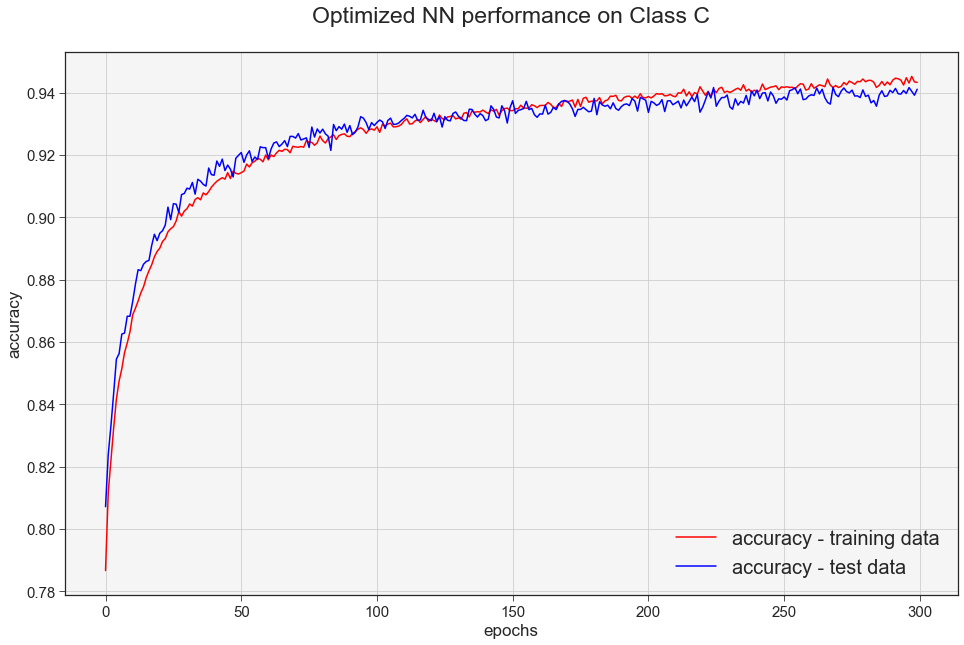

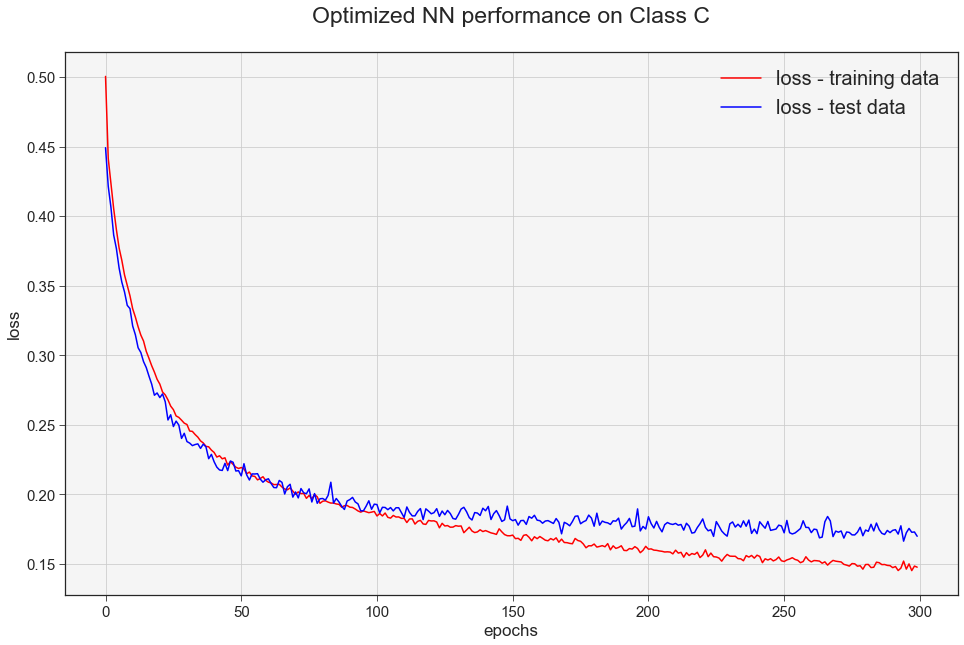

In [20]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class C\n', fontsize = 23) 
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

# Neural Network for class A ($\alpha$ helix)

There are $29295$ $\alpha$ helix proteins, (Class **C** $=1$), for which we have $5$ labels in class **A**. 


In [21]:
y_true = np.zeros(y.shape,dtype=int)
y = y[y != 'nan']
for i in range(len(y)):

    g = y[i].split('.')
    g = g[0] + g[1]
    y_true[i] = int(g)

In [22]:
x_1 = x[:c1, :]
y_label = y_true[:c1]
uniqs, counts = np.unique(y_label, return_counts= True)
print("Labels in class C = 1: ", uniqs)
print("Number of proteins in each label: ", counts)

Labels in class C = 1:  [110 120 125 140 150]
Number of proteins in each label:  [11204  2876   269     2   147]


In [23]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_label)

# Binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_label = onehot_encoder.fit_transform(integer_encoded)

x_standard = StandardScaler().fit_transform(x_1)
print('X shape: ', x_standard.shape)
print('y shape: ', y_label.shape)

X shape:  (14498, 15)
y shape:  (14498, 5)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

### Neural Network

The architecture of the model is similar to the previous one, but here we have about $15000$ samples. 

So we reduce the number of neurons in the hidden layers, to avoid overfitting.

In [25]:
def create_model_2(activation='relu',optimizer='adam',dropout_rate=0.2, L = 15):
    # create model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(50,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(70,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(5, activation = 'softmax'))
    print(model.summary())

    # compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
model_2 = create_model_2()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_19 (Dense)             (None, 50)                800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 70)                3570      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 30)                2130      
_________________________________________________________________
dense_22 (Dense)             (None, 5)                

In [26]:
model_2 = create_model_2()

fit = model_2.fit(X_train, y_train,
               epochs = 300, batch_size = 50,
               validation_data = (X_test,y_test),
               shuffle = True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_24 (Dense)             (None, 50)                800       
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 70)                3570      
_________________________________________________________________
dropout_5 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 30)                2130      
_________________________________________________________________
dense_27 (Dense)             (None, 5)                

11598/11598 [==============================] - 1s 50us/sample - loss: 0.3166 - accuracy: 0.8805 - val_loss: 0.3280 - val_accuracy: 0.8766
Epoch 101/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.3120 - accuracy: 0.8798 - val_loss: 0.3233 - val_accuracy: 0.8797
Epoch 102/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.3144 - accuracy: 0.8811 - val_loss: 0.3235 - val_accuracy: 0.8797
Epoch 103/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.3131 - accuracy: 0.8812 - val_loss: 0.3270 - val_accuracy: 0.8807
Epoch 104/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.3137 - accuracy: 0.8833 - val_loss: 0.3242 - val_accuracy: 0.8807
Epoch 105/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.3127 - accuracy: 0.8821 - val_loss: 0.3294 - val_accuracy: 0.8828
Epoch 106/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.3124 - accuracy:

Epoch 154/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2881 - accuracy: 0.8921 - val_loss: 0.2975 - val_accuracy: 0.8952
Epoch 155/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2918 - accuracy: 0.8884 - val_loss: 0.3042 - val_accuracy: 0.8883
Epoch 156/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2839 - accuracy: 0.8950 - val_loss: 0.2988 - val_accuracy: 0.8883
Epoch 157/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2904 - accuracy: 0.8921 - val_loss: 0.3012 - val_accuracy: 0.8907
Epoch 158/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2809 - accuracy: 0.8937 - val_loss: 0.3052 - val_accuracy: 0.8879
Epoch 159/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2836 - accuracy: 0.8939 - val_loss: 0.3051 - val_accuracy: 0.8852
Epoch 160/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.28

Epoch 208/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2701 - accuracy: 0.8979 - val_loss: 0.2932 - val_accuracy: 0.8938
Epoch 209/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2691 - accuracy: 0.9003 - val_loss: 0.2803 - val_accuracy: 0.8976
Epoch 210/300
11598/11598 [==============================] - 1s 51us/sample - loss: 0.2730 - accuracy: 0.8956 - val_loss: 0.2948 - val_accuracy: 0.8883
Epoch 211/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2660 - accuracy: 0.9012 - val_loss: 0.2854 - val_accuracy: 0.8955
Epoch 212/300
11598/11598 [==============================] - 1s 51us/sample - loss: 0.2630 - accuracy: 0.9023 - val_loss: 0.2868 - val_accuracy: 0.8903
Epoch 213/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2675 - accuracy: 0.8996 - val_loss: 0.2885 - val_accuracy: 0.8955
Epoch 214/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.27

Epoch 262/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2604 - accuracy: 0.9010 - val_loss: 0.2927 - val_accuracy: 0.8979
Epoch 263/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2572 - accuracy: 0.9010 - val_loss: 0.2779 - val_accuracy: 0.9003
Epoch 264/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2533 - accuracy: 0.9035 - val_loss: 0.2865 - val_accuracy: 0.9017
Epoch 265/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2520 - accuracy: 0.9077 - val_loss: 0.2844 - val_accuracy: 0.8979
Epoch 266/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2584 - accuracy: 0.9015 - val_loss: 0.2952 - val_accuracy: 0.8966
Epoch 267/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.2626 - accuracy: 0.9014 - val_loss: 0.2905 - val_accuracy: 0.8955
Epoch 268/300
11598/11598 [==============================] - 1s 50us/sample - loss: 0.25

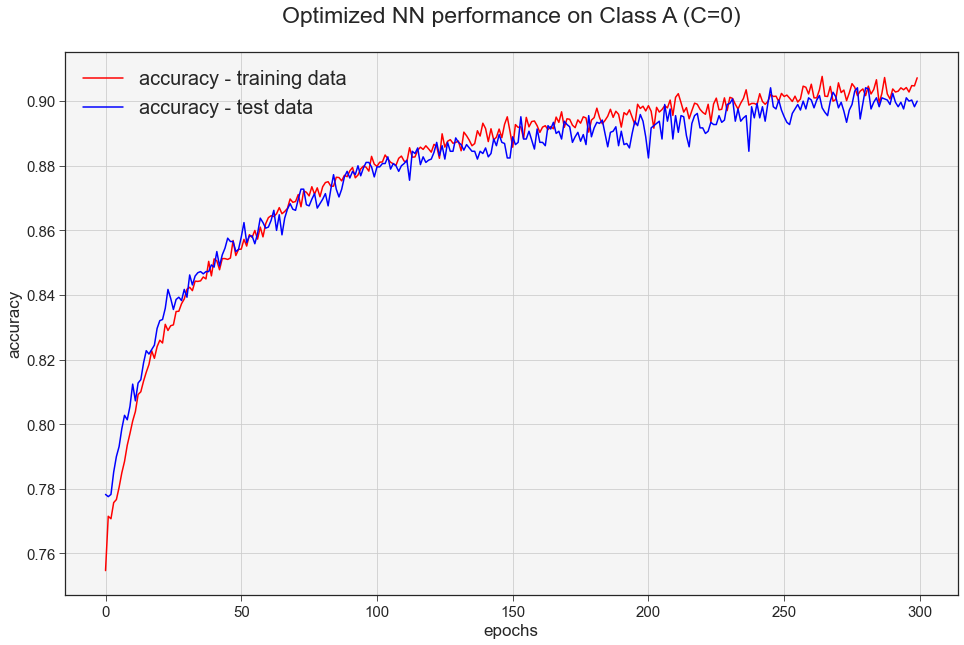

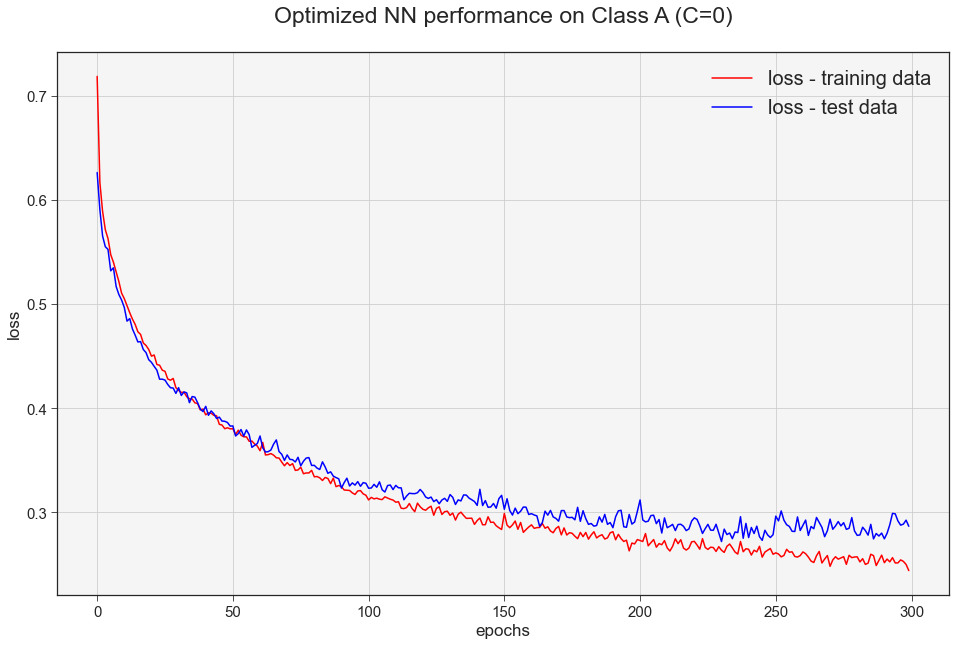

In [27]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class A (C=0)\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

# Neural Network for class A ($\beta$ sheet)

There are $22318$ $\beta$ sheet proteins, (Class **C** $=2$), for which we have $20$ labels in class **A**. But under some labels there are very few elements, so we neglect those categories.

We end up with $21995$ and $11$ labels.

In [28]:
x_1 = x[c1:c2, :]
y_label = y_true[c1:c2]
uniqs, counts = np.unique(y_label, return_counts= True)
print("Labels in class C = 2: ", uniqs)
print("Number of proteins in each label: ", counts)

Labels in class C = 2:  [ 210  220  230  240  250  260  270  280  290 2100 2102 2110 2115 2120
 2130 2140 2150 2160 2170]
Number of proteins in each label:  [  920   297  1962  5990    30 10500   761   358    41    90    63    15
    60   311   292    11    13   308   296]


In [29]:
cancel = [2180, 2150, 2140, 2115, 2110, 2102, 2100, 290, 250]
cancel.sort()

i_idx = []
for can in cancel:
    for i in range(len(y_label)):
        if y_label[i] == can:
            i_idx.append(i)
y_label = np.delete(y_label, i_idx)
x_1 = np.delete(x_1, i_idx,0)

In [30]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_label)

# Binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_label = onehot_encoder.fit_transform(integer_encoded)

x_standard = StandardScaler().fit_transform(x_1)
print('X shape: ', x_standard.shape)
print('y shape: ', y_label.shape)

X shape:  (21995, 15)
y shape:  (21995, 11)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

### Neural Network

Here we adapt again the architecture of the network in order to find the best results for $22000$ samples.

In [32]:
def create_model_3(activation='relu',optimizer='adam',dropout_rate=0.1, L = 15):
    # create model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(50,activation = activation))
    
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(100,activation = activation))
    model.add(Dense(50,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(11, activation = 'softmax'))
    print(model.summary())

    # compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
model_3 = create_model_3()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_29 (Dense)             (None, 50)                800       
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_31 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 30)               

In [33]:
model_3 = create_model_3()

fit = model_3.fit(X_train, y_train,
               epochs = 300, batch_size = 50,
               validation_data = (X_test,y_test),
               shuffle = True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_35 (Dense)             (None, 50)                800       
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_37 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 30)               

17596/17596 [==============================] - 1s 76us/sample - loss: 0.3363 - accuracy: 0.8793 - val_loss: 0.3462 - val_accuracy: 0.8891
Epoch 100/300
17596/17596 [==============================] - 1s 64us/sample - loss: 0.3439 - accuracy: 0.8772 - val_loss: 0.3433 - val_accuracy: 0.8907
Epoch 101/300
17596/17596 [==============================] - 1s 59us/sample - loss: 0.3426 - accuracy: 0.8785 - val_loss: 0.3418 - val_accuracy: 0.8902
Epoch 102/300
17596/17596 [==============================] - 1s 53us/sample - loss: 0.3395 - accuracy: 0.8785 - val_loss: 0.3488 - val_accuracy: 0.8857
Epoch 103/300
17596/17596 [==============================] - 1s 53us/sample - loss: 0.3461 - accuracy: 0.8771 - val_loss: 0.3499 - val_accuracy: 0.8859
Epoch 104/300
17596/17596 [==============================] - 1s 53us/sample - loss: 0.3378 - accuracy: 0.8800 - val_loss: 0.3452 - val_accuracy: 0.8888
Epoch 105/300
17596/17596 [==============================] - 1s 58us/sample - loss: 0.3387 - accuracy:

Epoch 153/300
17596/17596 [==============================] - 1s 56us/sample - loss: 0.2972 - accuracy: 0.8924 - val_loss: 0.3296 - val_accuracy: 0.8986
Epoch 154/300
17596/17596 [==============================] - 1s 56us/sample - loss: 0.2965 - accuracy: 0.8954 - val_loss: 0.3335 - val_accuracy: 0.8972
Epoch 155/300
17596/17596 [==============================] - 1s 56us/sample - loss: 0.2969 - accuracy: 0.8955 - val_loss: 0.3180 - val_accuracy: 0.9038
Epoch 156/300
17596/17596 [==============================] - 1s 58us/sample - loss: 0.2935 - accuracy: 0.8962 - val_loss: 0.3135 - val_accuracy: 0.9041
Epoch 157/300
17596/17596 [==============================] - 1s 58us/sample - loss: 0.3008 - accuracy: 0.8908 - val_loss: 0.3153 - val_accuracy: 0.9036
Epoch 158/300
17596/17596 [==============================] - 1s 62us/sample - loss: 0.2915 - accuracy: 0.8949 - val_loss: 0.3163 - val_accuracy: 0.9029
Epoch 159/300
17596/17596 [==============================] - 1s 61us/sample - loss: 0.29

Epoch 207/300
17596/17596 [==============================] - 1s 61us/sample - loss: 0.2711 - accuracy: 0.9044 - val_loss: 0.3341 - val_accuracy: 0.8997
Epoch 208/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.2705 - accuracy: 0.9044 - val_loss: 0.3010 - val_accuracy: 0.9111
Epoch 209/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.2681 - accuracy: 0.9028 - val_loss: 0.3071 - val_accuracy: 0.9070
Epoch 210/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.2630 - accuracy: 0.9062 - val_loss: 0.3129 - val_accuracy: 0.9070
Epoch 211/300
17596/17596 [==============================] - 1s 59us/sample - loss: 0.2599 - accuracy: 0.9081 - val_loss: 0.3104 - val_accuracy: 0.9098
Epoch 212/300
17596/17596 [==============================] - 1s 63us/sample - loss: 0.2645 - accuracy: 0.9055 - val_loss: 0.3103 - val_accuracy: 0.9086
Epoch 213/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.26

Epoch 261/300
17596/17596 [==============================] - 1s 63us/sample - loss: 0.2500 - accuracy: 0.9120 - val_loss: 0.3107 - val_accuracy: 0.9104
Epoch 262/300
17596/17596 [==============================] - 1s 55us/sample - loss: 0.2499 - accuracy: 0.9116 - val_loss: 0.2998 - val_accuracy: 0.9143
Epoch 263/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.2519 - accuracy: 0.9104 - val_loss: 0.3043 - val_accuracy: 0.9107
Epoch 264/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.2441 - accuracy: 0.9126 - val_loss: 0.3002 - val_accuracy: 0.9136
Epoch 265/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.2519 - accuracy: 0.9133 - val_loss: 0.2961 - val_accuracy: 0.9120
Epoch 266/300
17596/17596 [==============================] - 1s 55us/sample - loss: 0.2556 - accuracy: 0.9095 - val_loss: 0.3000 - val_accuracy: 0.9113
Epoch 267/300
17596/17596 [==============================] - 1s 54us/sample - loss: 0.25

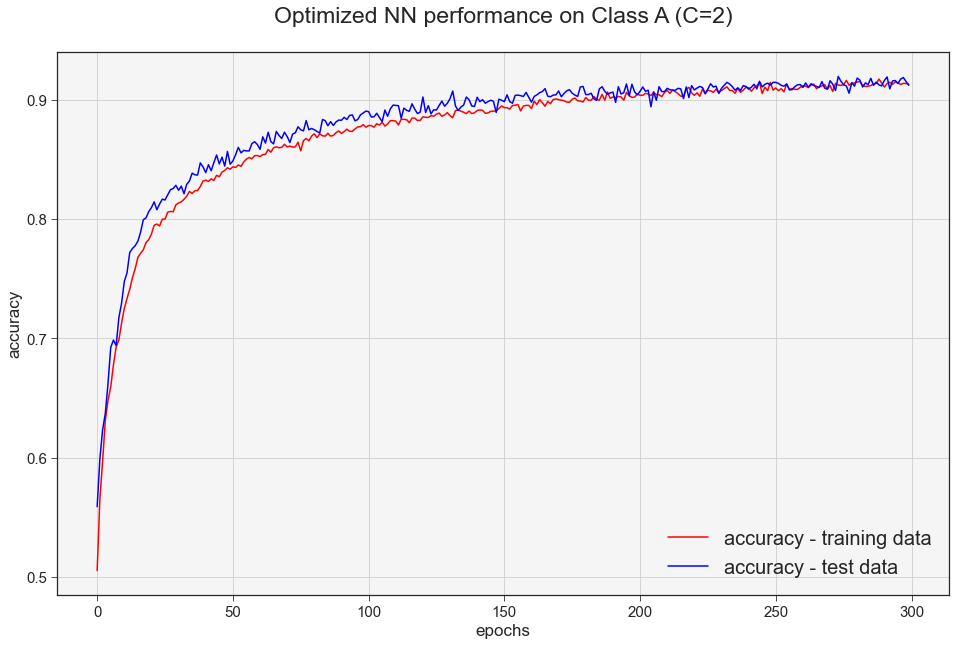

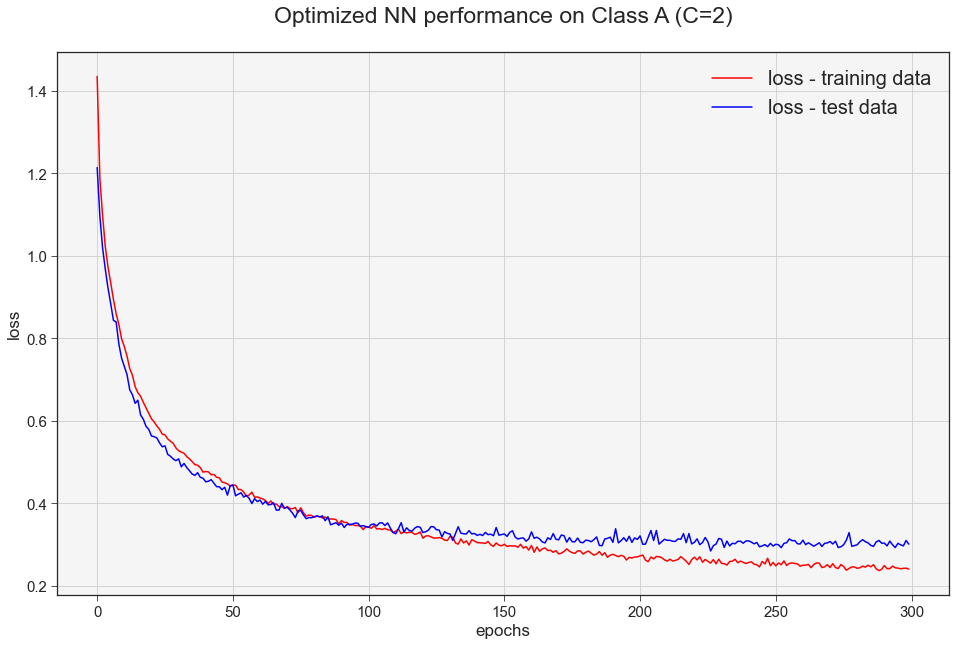

In [34]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class A (C=2)\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

# Neural Network for class A ($\alpha\beta$ )

There are $36588$ $\alpha\beta$  proteins, (Class **C** $=3$), for which we have $15$ labels in class **A**. But under some labels there are very few elements, so we neglict those categories.

We end up with $36365$ and $8$ labels.

In [35]:
x_1 = x[c2:c3, :]
y_label = y_true[c2:c3]
uniqs, counts = np.unique(y_label, return_counts= True)
print("Labels in class C = 3: ", uniqs)
print("Number of proteins in each label: ", counts)

Labels in class C = 3:  [ 310  315  320  330  340  350  355  360  365  370  375  380  390 3100]
Number of proteins in each label:  [ 3628     7  3691  8444 15762   318    11  1299    71    61    42   108
  3115    31]


In [36]:
cancel = [315, 355,365,  370,  375, 3100]
cancel.sort()

i_idx = []
for can in cancel:
    for i in range(len(y_label)):
        if y_label[i] == can:
            i_idx.append(i)
y_label = np.delete(y_label, i_idx)
x_1 = np.delete(x_1, i_idx,0)

In [37]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_label)

# Binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_label = onehot_encoder.fit_transform(integer_encoded)

x_standard = StandardScaler().fit_transform(x_1)
print('X shape: ', x_standard.shape)
print('y shape: ', y_label.shape)

X shape:  (36365, 15)
y shape:  (36365, 8)


### Neural Network

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_label, train_size=0.8, random_state = 123)

In [39]:
def create_model_4(activation='relu',optimizer='adam',dropout_rate=0.1, L = 15):
    # create model
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = activation))
    model.add(Dense(70,activation = activation))
    
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(100,activation = activation))
    model.add(Dense(50,activation = activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(30,activation = activation))
    model.add(Dense(8, activation = 'softmax'))
    print(model.summary())

    # compile model
    model.compile( loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
model_4 = create_model_4()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_41 (Dense)             (None, 70)                1120      
_________________________________________________________________
dropout_10 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               7100      
_________________________________________________________________
dense_43 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 30)               

In [40]:

fit = model_4.fit(X_train, y_train,
               epochs = 300, batch_size = 50,
               validation_data = (X_test,y_test),
               shuffle = True)

Train on 29092 samples, validate on 7273 samples
Epoch 1/300
29092/29092 [==============================] - 2s 72us/sample - loss: 1.2835 - accuracy: 0.5306 - val_loss: 1.1011 - val_accuracy: 0.5812
Epoch 2/300
29092/29092 [==============================] - 2s 54us/sample - loss: 1.0803 - accuracy: 0.5840 - val_loss: 1.0162 - val_accuracy: 0.6081
Epoch 3/300
29092/29092 [==============================] - 2s 54us/sample - loss: 1.0076 - accuracy: 0.6135 - val_loss: 0.9623 - val_accuracy: 0.6307
Epoch 4/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.9502 - accuracy: 0.6382 - val_loss: 0.9065 - val_accuracy: 0.6559
Epoch 5/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.9031 - accuracy: 0.6601 - val_loss: 0.8591 - val_accuracy: 0.6836
Epoch 6/300
29092/29092 [==============================] - 2s 60us/sample - loss: 0.8718 - accuracy: 0.6780 - val_loss: 0.8408 - val_accuracy: 0.6816
Epoch 7/300
29092/29092 [==========================

Epoch 55/300
29092/29092 [==============================] - 2s 60us/sample - loss: 0.5057 - accuracy: 0.8147 - val_loss: 0.5036 - val_accuracy: 0.8243
Epoch 56/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.5049 - accuracy: 0.8142 - val_loss: 0.5030 - val_accuracy: 0.8202
Epoch 57/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.5019 - accuracy: 0.8149 - val_loss: 0.4960 - val_accuracy: 0.8254
Epoch 58/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.4932 - accuracy: 0.8202 - val_loss: 0.5163 - val_accuracy: 0.8160
Epoch 59/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.4997 - accuracy: 0.8177 - val_loss: 0.4955 - val_accuracy: 0.8270
Epoch 60/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.4969 - accuracy: 0.8176 - val_loss: 0.4916 - val_accuracy: 0.8255
Epoch 61/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.4899 - ac

Epoch 163/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3908 - accuracy: 0.8571 - val_loss: 0.4304 - val_accuracy: 0.8552
Epoch 164/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3899 - accuracy: 0.8595 - val_loss: 0.4283 - val_accuracy: 0.8545
Epoch 165/300
29092/29092 [==============================] - 2s 59us/sample - loss: 0.3866 - accuracy: 0.8605 - val_loss: 0.4304 - val_accuracy: 0.8589
Epoch 166/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3923 - accuracy: 0.8577 - val_loss: 0.4247 - val_accuracy: 0.8620
Epoch 167/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3894 - accuracy: 0.8562 - val_loss: 0.4241 - val_accuracy: 0.8582
Epoch 168/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3874 - accuracy: 0.8596 - val_loss: 0.4275 - val_accuracy: 0.8556
Epoch 169/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.38

Epoch 217/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3637 - accuracy: 0.8667 - val_loss: 0.4153 - val_accuracy: 0.8650
Epoch 218/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3698 - accuracy: 0.8656 - val_loss: 0.4165 - val_accuracy: 0.8665
Epoch 219/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3630 - accuracy: 0.8669 - val_loss: 0.4249 - val_accuracy: 0.8636
Epoch 220/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3674 - accuracy: 0.8667 - val_loss: 0.4226 - val_accuracy: 0.8668
Epoch 221/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3677 - accuracy: 0.8655 - val_loss: 0.4239 - val_accuracy: 0.8611
Epoch 222/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.3668 - accuracy: 0.8656 - val_loss: 0.4271 - val_accuracy: 0.8620
Epoch 223/300
29092/29092 [==============================] - 2s 54us/sample - loss: 0.36

Epoch 271/300
29092/29092 [==============================] - 2s 59us/sample - loss: 0.3562 - accuracy: 0.8708 - val_loss: 0.4122 - val_accuracy: 0.8675
Epoch 272/300
29092/29092 [==============================] - 2s 58us/sample - loss: 0.3554 - accuracy: 0.8709 - val_loss: 0.4107 - val_accuracy: 0.8710
Epoch 273/300
29092/29092 [==============================] - 2s 60us/sample - loss: 0.3497 - accuracy: 0.8706 - val_loss: 0.4109 - val_accuracy: 0.8665
Epoch 274/300
29092/29092 [==============================] - 2s 55us/sample - loss: 0.3512 - accuracy: 0.8729 - val_loss: 0.4102 - val_accuracy: 0.8633
Epoch 275/300
29092/29092 [==============================] - 2s 55us/sample - loss: 0.3512 - accuracy: 0.8724 - val_loss: 0.3994 - val_accuracy: 0.8724
Epoch 276/300
29092/29092 [==============================] - 2s 57us/sample - loss: 0.3559 - accuracy: 0.8693 - val_loss: 0.3909 - val_accuracy: 0.8725
Epoch 277/300
29092/29092 [==============================] - 2s 56us/sample - loss: 0.35

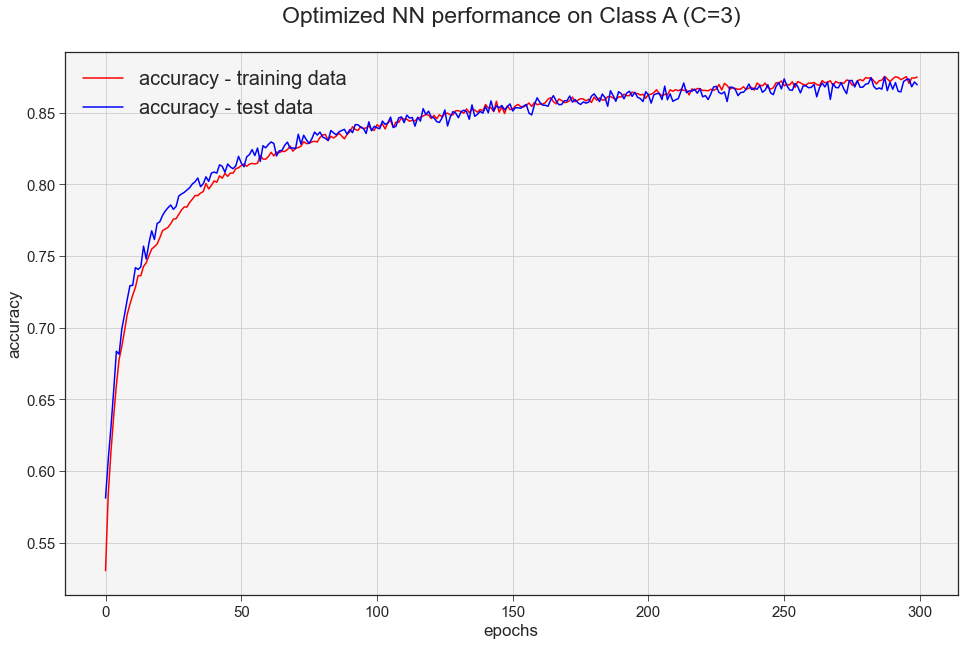

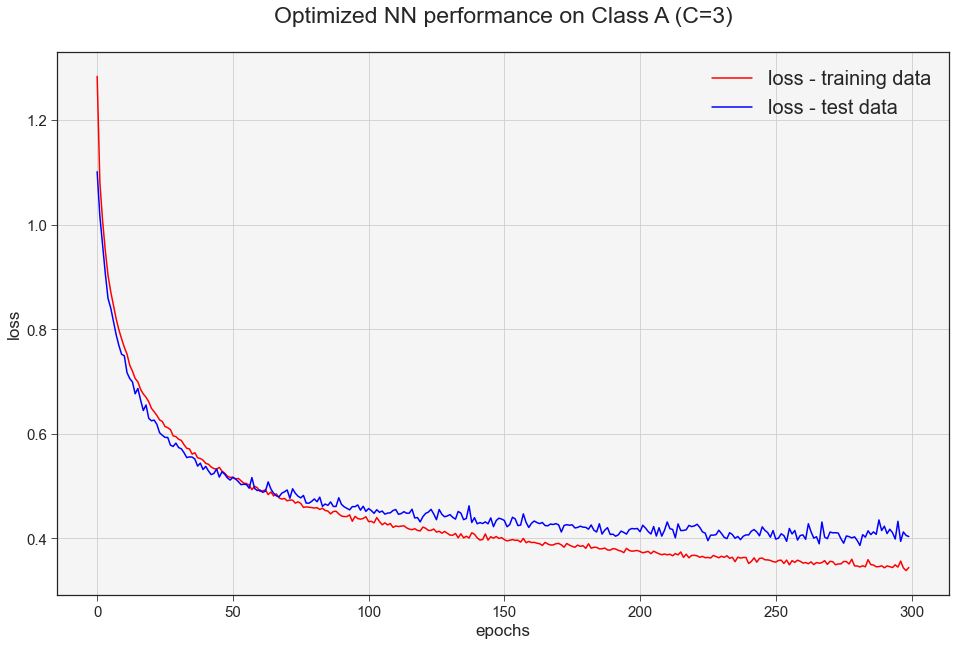

In [41]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize=(16,10))
    plt.style.use('seaborn-ticks')
    plt.plot(fit.history[obs], 'r', label = obs +' - training data')
    plt.plot(fit.history['val_' + obs], 'b', label = obs + ' - test data')
    plt.title('Optimized NN performance on Class A (C=3)\n', fontsize = 23)
    ax = plt.subplot()
    ax.set_facecolor("whitesmoke")
    plt.xlabel('epochs', fontsize = 17)
    plt.ylabel(obs, fontsize = 17)
    plt.legend(loc = "best", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.grid()
    plt.show()

# Conclusions 
 
- We have seen how to compute the features we have defined. Their computation is faster than the one of those used in the paper we have been referring to. 
- We have tried to clustering our dataset using DBSCAN and KNeighborsClassifier. DBSCAN is not able to recognize the $3$ C clusters. This is because it is a density-based clustering and in our case, after we projected the data into 2D plane, we have just one big cloud of points. On the other hand, KNeighborsClassifier performs better (reaching a score of about $80$%), in according to the original classification method used in the paper. 
- We used the original classification algorithm of the paper (`KNeighborsClassifier`) and original features. We have explored the whole CATH classification and we achieve optimal results. 
- We decided to implement a Neural Network using the features we have defined. This because, even if they are less accurate in the classification w.r.t. the original features, they are so much faster to compute, we obtain good results with different architectures and also the training phase of the NN is very fast.

We have seen that the protein chains are very easy to classify using features based on Gaussian Integrals and topological invariant. This should make faster the process of identify and classify new chains, since using KNeighborsClassifier we reach a score very close to $1$. 
 
On the other hand, even if the features identify by our own have not topological meaning, they represents nearest and nearest couple segments (of the chain) interaction.